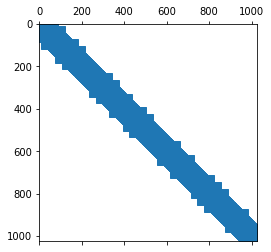

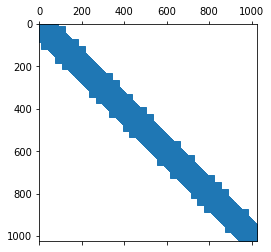

In [23]:
import scipy.sparse
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from pygsp.graphs import Graph
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


pos = 470

L = scipy.sparse.load_npz('matrices/stiffness_matrix.npz')
B = scipy.sparse.load_npz('matrices/mass_matrix.npz')
reordering_mask = np.load("reordering_mask.npy")


npix = 1025

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]
B_inv = scipy.sparse.linalg.inv(B)
signal = np.zeros(npix)
signal[0] = 1

B_lumped_inverse = np.diag(1./np.sum(B.toarray(), axis=1))


plt.spy(L)
plt.show()
plt.spy(B)
plt.show()

# FEM diffusion


In [8]:
class Equiangulartovtk(Graph):
     
    def make_coords(self):
        alpha = np.arange(2 * 16) * np.pi / 16
        l = 1
        alpha1 = np.linspace(0, l, 14, endpoint=False)
        alpha2 = np.linspace(l, np.pi-l, 5, endpoint=False)
        alpha3 = np.linspace(np.pi-l, np.pi, 14, endpoint=False)        
        beta = np.concatenate([alpha1, alpha2, alpha3])
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        return coords[2*16-1:]

    def __init__(self):
        from pyevtk.hl import unstructuredGridToVTK
        from pyevtk.vtk import VtkTriangle, VtkQuad
        
        self.coords = self.make_coords()
        self.x = self.coords[:,0]
        self.y = self.coords[:,1]
        self.z = self.coords[:,2]
        
        
        
                
       
        tri = ConvexHull(self.coords)
        
        
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid
        distances_squared = scipy.spatial.distance.cdist(self.coords, self.coords)**2
        W = np.exp(-distances_squared/0.1)
        W = W-np.diag(np.diag(W))
        super(Equiangulartovtk, self).__init__(W=W, coords=self.coords)

    def save(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})


In [10]:
M = scipy.linalg.expm(-0.08*B_inv@L)
M_lumped = scipy.linalg.expm(-0.08*B_lumped_inverse@L)

In [26]:
def diffuse(x):
    return M@x

def diffuse_lumped(x):
    return M_lumped@x

signal = np.zeros(npix)
signal[pos] = 1

graph = Equiangulartovtk()
graph.save('img/FEM_diffusion000000{}'.format(0), pointData = signal)
for j in range(8):
    # diffusing 3 times
    for i in range(1):
        signal = np.asarray(abs(diffuse(signal)))
    graph.save('img/FEM_diffusion000000{}'.format(j+1), pointData = signal)


# GRAPH diffusion

In [16]:
graph = Equiangulartovtk()
HKGL = graph.L

expL = scipy.linalg.expm(-0.05*HKGL)
def diffuse_HKGL(x):
    return expL@x

In [27]:
from pygsp.graphs import Graph
# re initializing the signal to diffuse
signal = np.zeros(npix)
signal[pos] = 1
graph.save('img/GRAPH_diffusion000000{}'.format(0), pointData = signal)
for j in range(8):
    # diffusing 3 times
    for i in range(3):
        signal = diffuse_HKGL(signal)
    graph.save('img/GRAPH_diffusion000000{}'.format(j+1), pointData = signal)